### Import the libraries

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

### Loading of dataset

In [157]:
def load_wine_data(wine_type='red'):
    """
    Load wine dataset from UCI based on wine type.
    Args:
        wine_type (str): 'red' or 'white' to specify the wine type.
    Returns:
        pd.DataFrame: Loaded wine dataset.
    """
    url_map = {
        'red': "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
        'white': "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
    }
    if wine_type.lower() not in url_map:
        raise ValueError(f"Invalid wine type: {wine_type}. Choose 'red' or 'white'.")
    
    url = url_map[wine_type.lower()]
    try:
        df = pd.read_csv(url, sep=';')
    except Exception as e:
        raise RuntimeError(f"Failed to load data from {url}: {e}")
    
    return df

### Data preprocessing

In [158]:
def preprocess_data(df):
    """
    Scale features and separate the quality column.
    Args:
        df (pd.DataFrame): Wine dataset.
    Returns:
        np.ndarray: Scaled feature matrix.
        pd.DataFrame: Original dataframe.
    """
    if 'quality' not in df.columns:
        raise KeyError("The dataset does not contain a 'quality' column.")
    
    X = df.drop(columns=['quality'])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, df

### Applying KMeans clustering

In [159]:
def apply_kmeans(X_scaled, n_clusters=2):
    """
    Apply KMeans clustering to the scaled data.
    Args:
        X_scaled (np.ndarray): Scaled feature matrix.
        n_clusters (int): Number of clusters.
    Returns:
        np.ndarray: Cluster labels.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    return labels

### Computing the Gaussian Probability Density Function (PDF)

In [160]:
def compute_gaussian_pdf(X_scaled):
    """
    Estimate the PDF of a multivariate normal distribution.
    Args:
        X_scaled (np.ndarray): Scaled feature matrix.
    Returns:
        np.ndarray: PDF values for each data point.
    """
    mean = np.mean(X_scaled, axis=0)
    cov = np.cov(X_scaled, rowvar=False)
    pdf = multivariate_normal(mean=mean, cov=cov).pdf(X_scaled)
    return pdf

### Detecting anomalies

In [161]:
def detect_anomalies(pdf, percentile=2):
    """
    Detect anomalies based on a percentile threshold.
    Args:
        pdf (np.ndarray): PDF values for each data point.
        percentile (float): Percentile threshold for anomaly detection.
    Returns:
        np.ndarray: Boolean mask for anomalies.
    """
    threshold = np.percentile(pdf, percentile)
    return pdf < threshold

### Visualizing the anomalies

In [162]:
def visualize_anomalies(X_scaled, anomalies_mask, title="Anomaly Detection with PCA"):
    """
    Visualize anomalies in 2D using PCA.
    Args:
        X_scaled (np.ndarray): Scaled feature matrix.
        anomalies_mask (np.ndarray): Boolean mask for anomalies.
        title (str): Title of the plot.
    """
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[~anomalies_mask, 0], X_pca[~anomalies_mask, 1], 
                c='black', label='Normal', alpha=0.5)
    plt.scatter(X_pca[anomalies_mask, 0], X_pca[anomalies_mask, 1], 
                c='red', label='Anomaly', alpha=0.8)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Visualizing the clusters

In [163]:
def visualize_clusters_2d(X_scaled, labels):
    """
    2D scatter plot of KMeans clusters with discrete color labels.
    """
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.6)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Cluster Label')
    plt.title("K-Means Clustering Visualization (2D PCA)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Plotting the PDF Histogram

In [164]:
def plot_pdf_histogram(pdf, threshold):
    """Histogram of PDF values with threshold line."""
    plt.figure(figsize=(8, 5))
    plt.hist(pdf, bins=50, color='skyblue', edgecolor='black')
    plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold: {threshold:.2e}")
    plt.title("Histogram of Gaussian PDF Values")
    plt.xlabel("Probability Density")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Plotting the PDF Boxplot

In [165]:
def plot_pdf_boxplot(pdf, threshold):
    """Boxplot of PDF values with anomaly threshold."""
    plt.figure(figsize=(6, 5))
    plt.boxplot(pdf, vert=False)
    plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold: {threshold:.2e}")
    plt.title("Boxplot of PDF Values")
    plt.xlabel("Probability Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Running the anomaly detection

In [166]:
def run_anomaly_detection(wine_type='red', k=2, anomaly_percentile=2):
    """
    Main function to run the entire anomaly detection pipeline.
    Args:
        wine_type (str): 'red' or 'white' to specify the wine type.
        k (int): Number of clusters for KMeans.
        anomaly_percentile (float): Percentile threshold for anomaly detection.
    Returns:
        pd.DataFrame: Dataframe with cluster and anomaly labels.
    """
    df = load_wine_data(wine_type)
    
    X_scaled, df = preprocess_data(df)
    
    labels = apply_kmeans(X_scaled, n_clusters=k)
    df['Cluster'] = labels
    
    pdf = compute_gaussian_pdf(X_scaled)
    threshold = np.percentile(pdf, anomaly_percentile)
    anomalies_mask = pdf < threshold
    df['Anomaly'] = anomalies_mask
    
    print(f"Wine type: {wine_type.capitalize()}")
    print(f"Total records: {len(df)}")
    print(f"Detected anomalies (bottom {anomaly_percentile}%): {anomalies_mask.sum()}")
    
        # Visualizations
    visualize_clusters_2d(X_scaled, labels)
    plot_pdf_histogram(pdf, threshold)
    plot_pdf_boxplot(pdf, threshold)
    visualize_anomalies(X_scaled, anomalies_mask)
    
    return df  # Return the dataframe with cluster and anomaly labels


Wine type: White
Total records: 4898
Detected anomalies (bottom 2%): 98


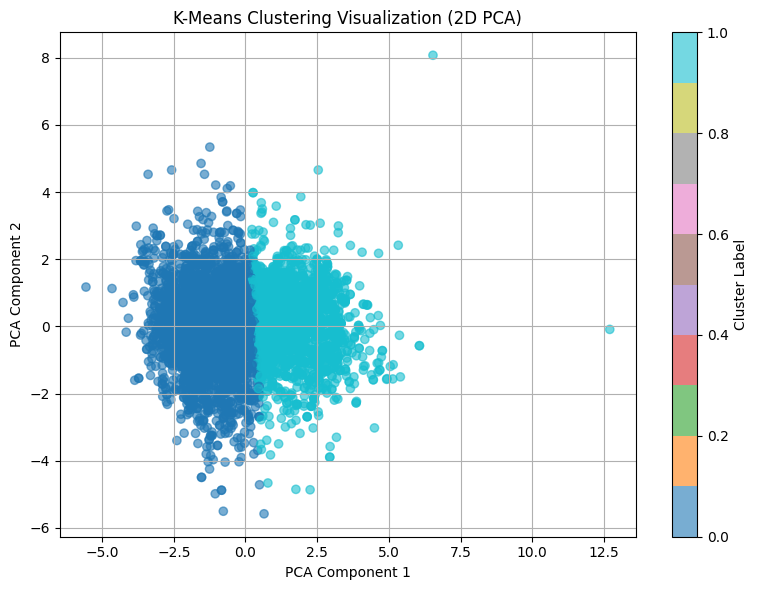

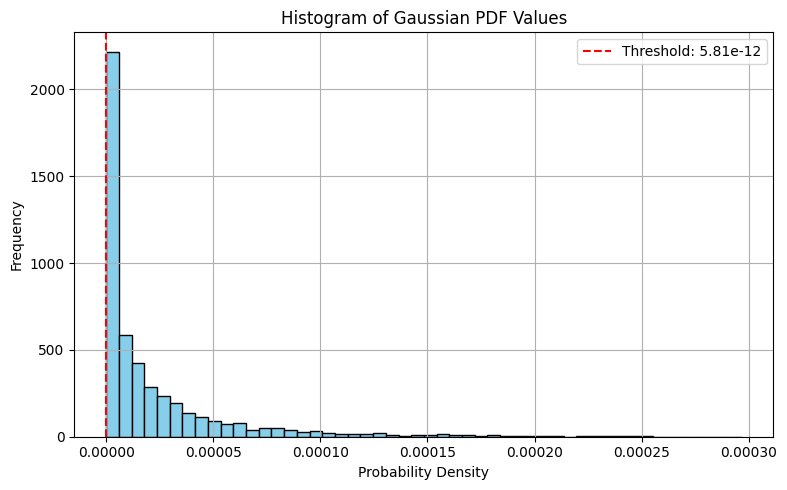

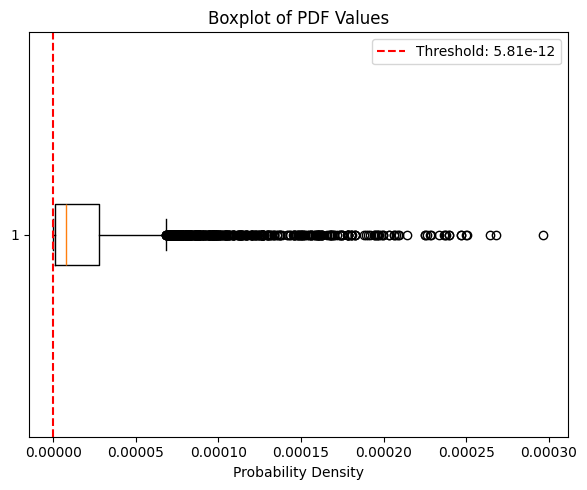

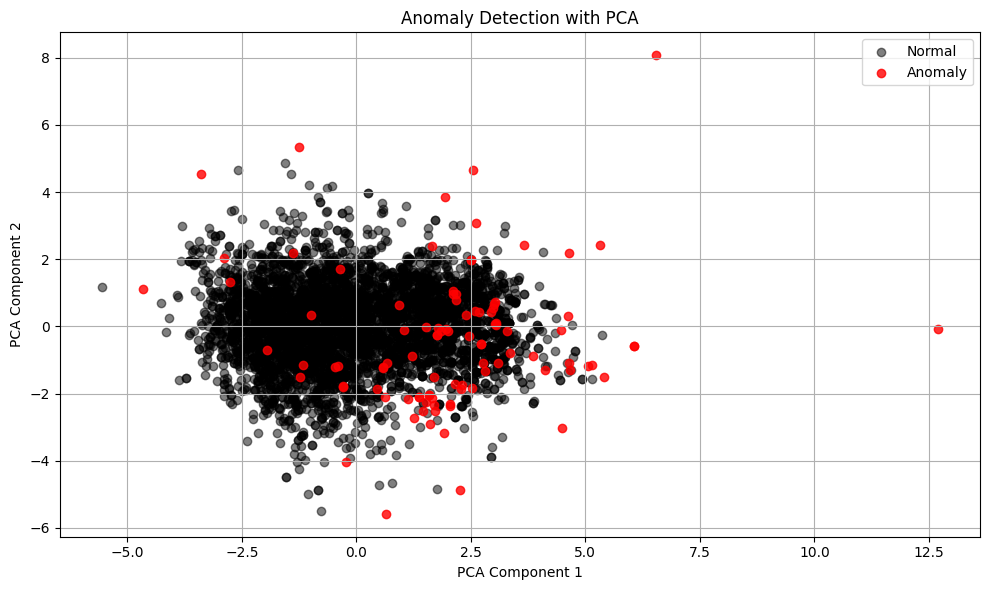

In [167]:
# Example usage
if __name__ == "__main__":
    df_results = run_anomaly_detection(wine_type='white', k=2, anomaly_percentile=2)
    # The function will print the number of detected anomalies and show a plot of the PCA results.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 1: Load the wine dataset from UCI

def load_wine_data(wine_type='white'):
    """
    Load wine dataset from UCI based on wine type.
    Args:
        wine_type (str): 'red' or 'white' to specify the wine type.
    Returns:
        pd.DataFrame: Loaded wine dataset.
    """
    url_map = {
        'red': "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
        'white': "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
    }
    if wine_type.lower() not in url_map:
        raise ValueError(f"Invalid wine type: {wine_type}. Choose 'red' or 'white'.")

    url = url_map[wine_type.lower()]
    df = pd.read_csv(url, sep=';')
    return df

# Step 2: Visualize feature distributions with Gaussian fits

def visualize_feature_distributions_with_fit(df):
    """
    Visualize the distributions of all features in the dataset with Gaussian fit.
    Args:
        df (pd.DataFrame): Wine dataset.
    """
    feature_names = df.columns[:-1]  # Exclude 'quality'
    num_features = len(feature_names)
    num_cols = 3
    num_rows = (num_features + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
    axes = axes.flatten()

    for i, feature in enumerate(feature_names):
        data = df[feature].dropna()
        mu, std = norm.fit(data)
        sns.histplot(data, bins=25, kde=False, stat='density', color='skyblue', ax=axes[i])
        x = np.linspace(*axes[i].get_xlim(), 100)
        p = norm.pdf(x, mu, std)
        axes[i].plot(x, p, 'k', linewidth=2)
        axes[i].set_title(f'{feature}\nFit: μ={mu:.2f}, σ={std:.2f}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Density')
        axes[i].grid(True)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Step 3: Test normality of a feature

def test_normality(data, feature_name):
    mu, std = norm.fit(data)
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=50, kde=False, stat='density', color='skyblue', edgecolor='black')
    x = np.linspace(*plt.xlim(), 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.title(f'Gaussian Fit on {feature_name}: μ={mu:.2f}, σ={std:.2f}')
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()
    return mu, std

# Step 4: Compute PDF values

def compute_pdf(data, mu, std):
    return norm.pdf(data, mu, std)

# Step 5: Apply KMeans clustering

def apply_kmeans(pdf_values, n_clusters=2):
    reshaped = pdf_values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reshaped)
    return kmeans.labels_, kmeans

# Step 6: Identify anomalies

def identify_anomalies(pdf_values, labels, kmeans):
    cluster_means = [pdf_values[labels == i].mean() for i in range(kmeans.n_clusters)]
    anomaly_cluster = np.argmin(cluster_means)
    return labels == anomaly_cluster

# Step 7: Compute silhouette scores

def compute_and_plot_silhouette_scores(pdf_values):
    sil_scores = []
    k_range = range(2, 10)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(pdf_values.reshape(-1, 1))
        sil_scores.append(silhouette_score(pdf_values.reshape(-1, 1), kmeans.labels_))

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sil_scores, marker='o', label='Silhouette Score')
    plt.axhline(y=np.mean(sil_scores), color='red', linestyle='--', label='Mean Score')
    plt.title('Silhouette Scores for Different k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Step 8: Visualize results

def visualize_results(data, pdf_values, anomalies, feature_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(pdf_values, bins=50, color='skyblue', edgecolor='black')
    plt.title('Histogram of PDF Values')
    plt.xlabel('PDF Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=pdf_values)
    plt.title('Boxplot of PDF Values')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(data)), data, c=~anomalies, cmap='coolwarm', edgecolor='k')
    plt.title(f'Anomaly Detection on {feature_name}')
    plt.xlabel('Index')
    plt.ylabel(feature_name)
    plt.grid(True)
    plt.show()

# Step 9: Run the full pipeline

def run_anomaly_detection(feature_name='residual sugar', wine_type='white'):
    print("Loading data...")
    df = load_wine_data(wine_type)

    print("Visualizing feature distributions with Gaussian fit...")
    visualize_feature_distributions_with_fit(df)

    data = df[feature_name].astype(float).values

    print(f"Testing normality of {feature_name}...")
    mu, std = test_normality(data, feature_name)

    print("Computing PDF values...")
    pdf_values = compute_pdf(data, mu, std)

    print("Applying KMeans clustering...")
    labels, kmeans = apply_kmeans(pdf_values)

    print("Identifying anomalies...")
    anomalies = identify_anomalies(pdf_values, labels, kmeans)

    print("Computing silhouette scores...")
    compute_and_plot_silhouette_scores(pdf_values)

    print("Visualizing results...")
    visualize_results(data, pdf_values, anomalies, feature_name)

    df['Anomaly'] = anomalies
    return df

# Example usage
if __name__ == '__main__':
    result_df = run_anomaly_detection(feature_name='alcohol', wine_type='white')
    print(result_df[['alcohol', 'Anomaly']].head())
    

Loading data...


C:\Users\Sean Xander Aquino\AppData\Local\Temp\ipykernel_14644\4240883436.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Visualizing feature distributions with Gaussian fit...


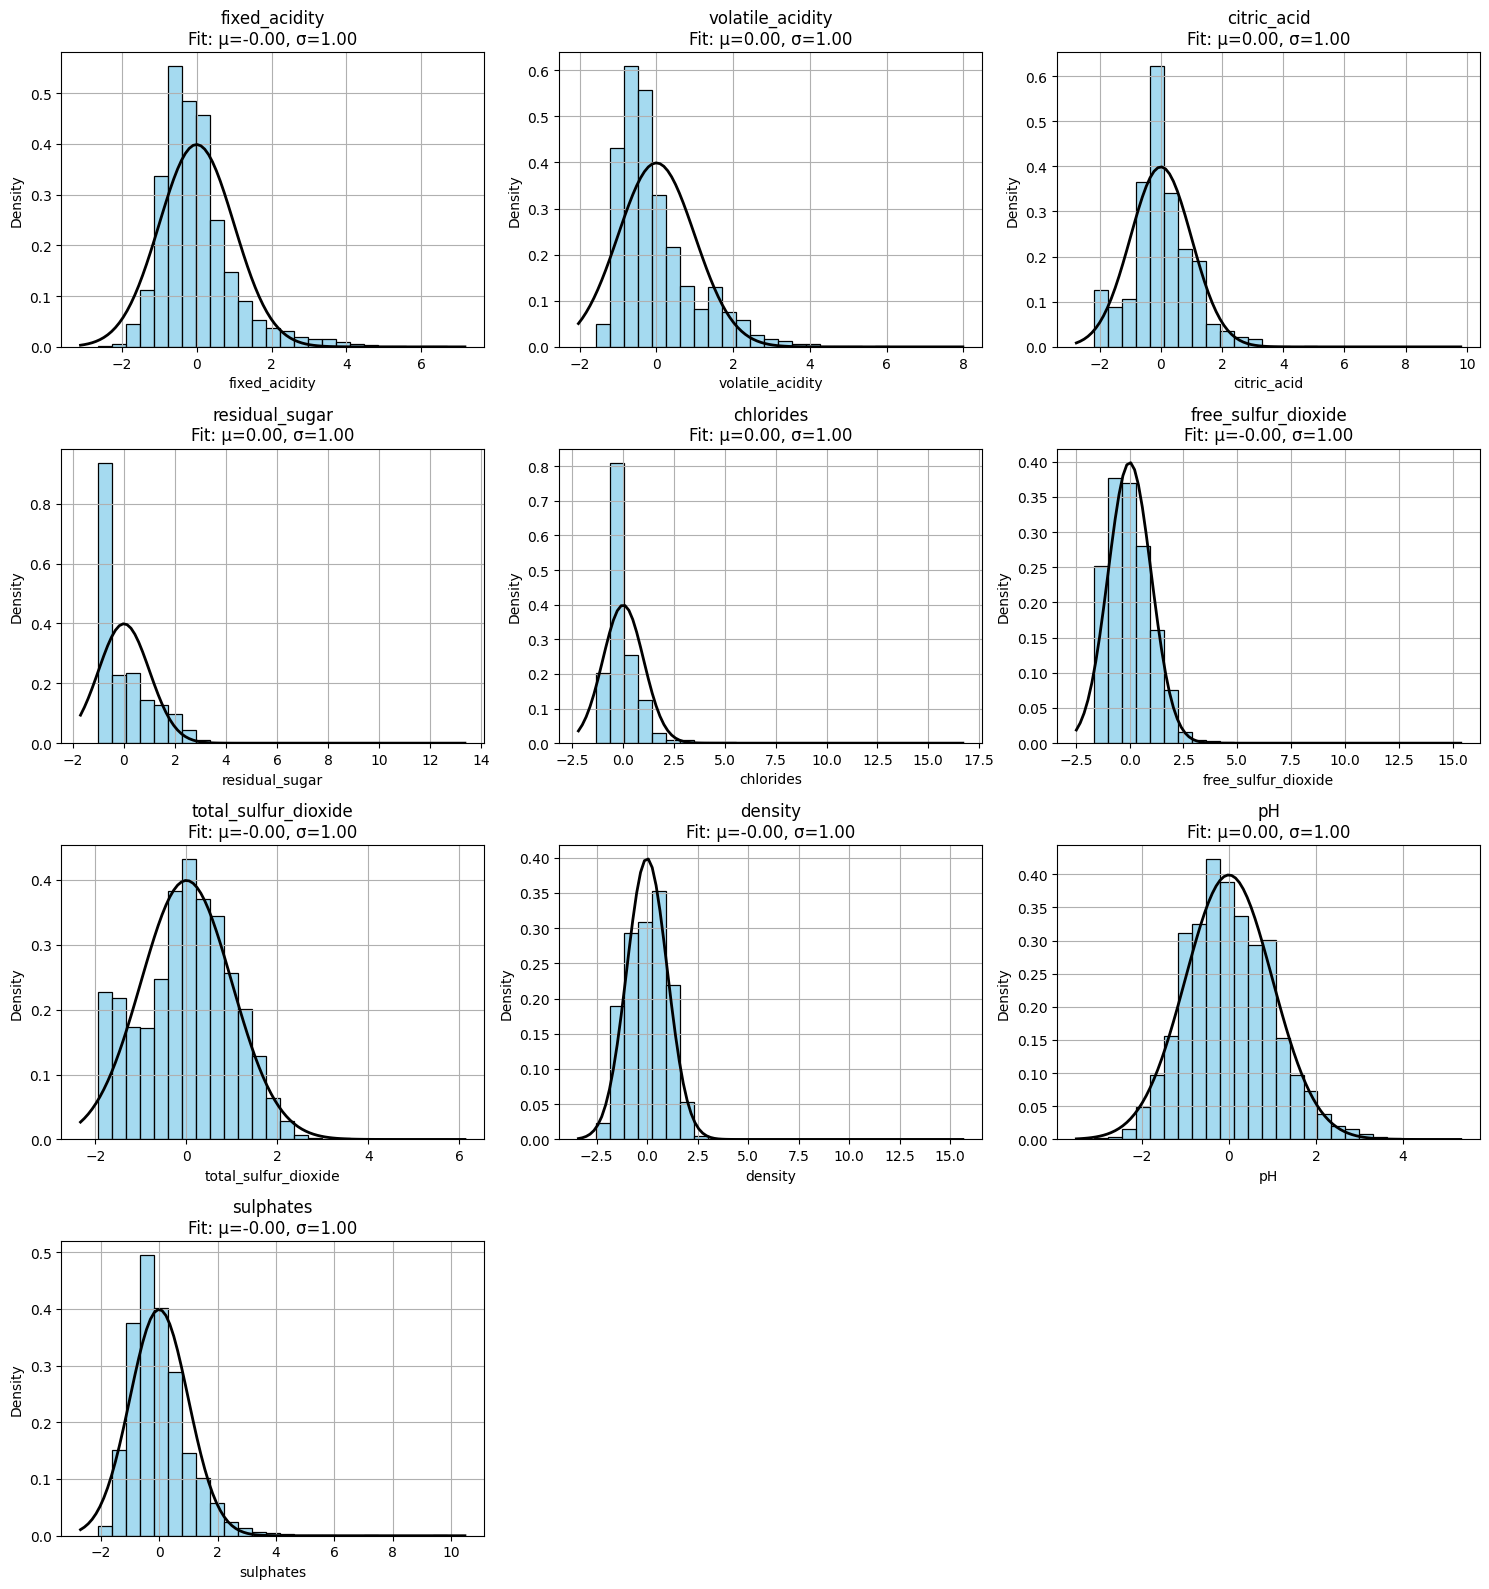

Testing normality for alcohol...


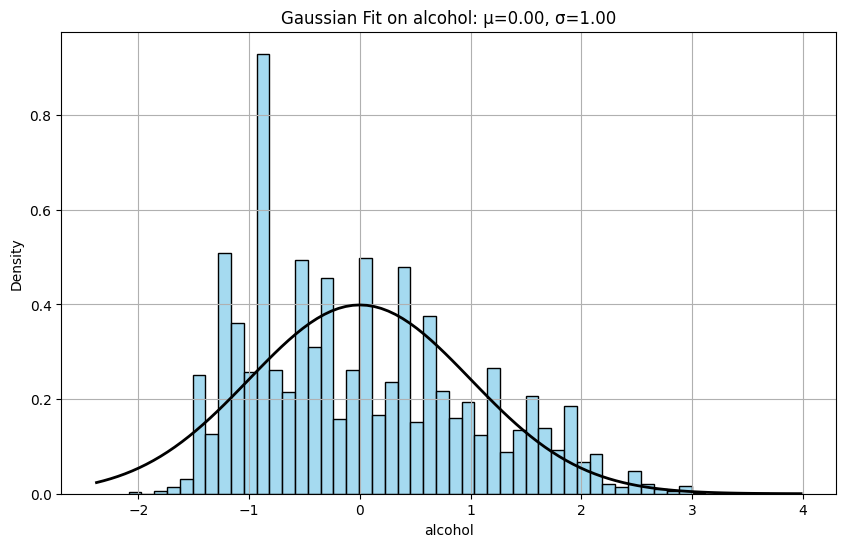

Computing PDF values...
Applying KMeans clustering...
Identifying anomalies...
Computing and plotting silhouette scores...


c:\Users\Sean Xander Aquino\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: ConvergenceWarning:

Number of distinct clusters (111) found smaller than n_clusters (112). Possibly due to duplicate points in X.

c:\Users\Sean Xander Aquino\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: ConvergenceWarning:

Number of distinct clusters (111) found smaller than n_clusters (113). Possibly due to duplicate points in X.

c:\Users\Sean Xander Aquino\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: ConvergenceWarning:

Number of distinct clusters (111) found smaller than n_clusters (114). Possibly due to duplicate points in X.

c:\Users\Sean Xander Aquino\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: ConvergenceWarning:

Number of distinct clusters (111) found smaller than n_clusters (115). Possibly due to duplicate points in X.

c:\Users\Sean Xander Aquino\AppData\Loca

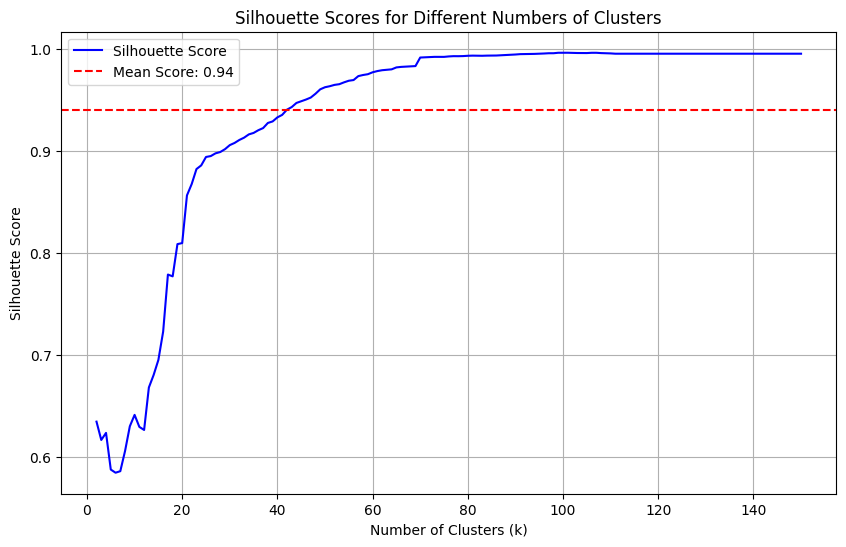

Visualizing results...


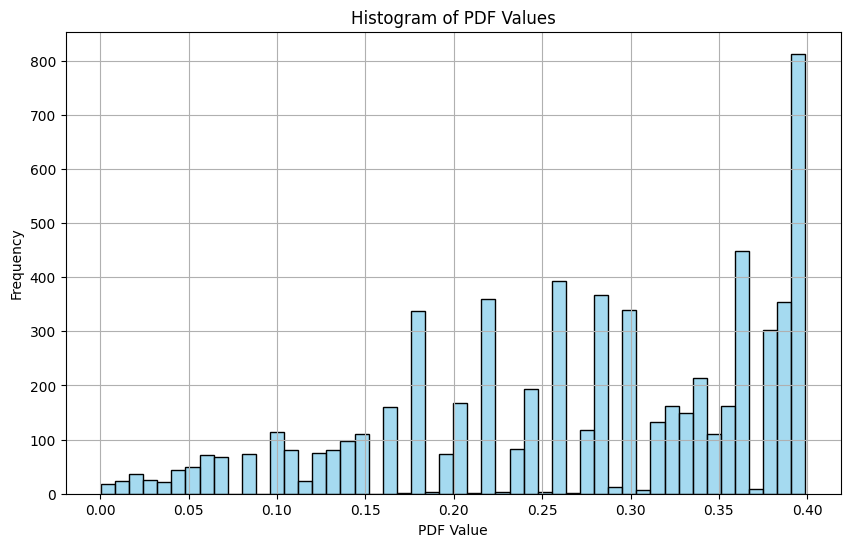

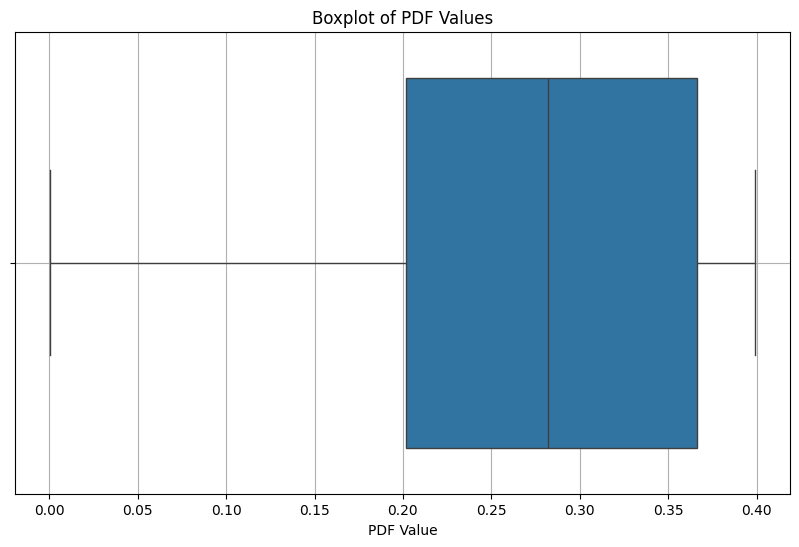

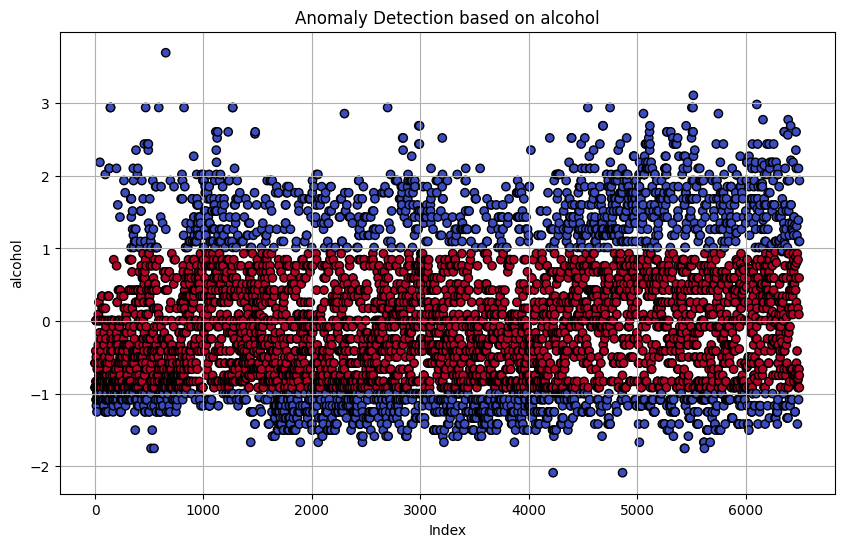

   alcohol  Anomaly
0      9.4    False
1      9.8    False
2      9.8    False
3      9.8    False
4      9.4    False


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo 

# Step 1: Load the wine dataset
def load_wine_data(wine_type='white'):
    """
    Load wine dataset from UCI based on wine type.
    Args:
        wine_type (str): 'red' or 'white' to specify the wine type.
    Returns:
        pd.DataFrame: Loaded wine dataset.
    """
    wine_quality = fetch_ucirepo(id=186) 
    df = wine_quality.data.features
    df['quality'] = wine_quality.data.targets
    return df

# Step 2: Visualize distributions of all features with Gaussian fits
def visualize_feature_distributions_with_fit(df):
    """
    Visualize the distributions of all features in the dataset with Gaussian fit.
    Args:
        df (pd.DataFrame): Wine dataset.
    """
    feature_names = df.columns[:-1]  # Exclude the 'quality' column
    num_features = len(feature_names)
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, feature in enumerate(feature_names):
        data = df[feature].dropna()  # Drop NaN values if any
        mu, std = norm.fit(data)  # Fit a Gaussian distribution
        sns.histplot(data, bins=25, kde=False, stat='density', color='skyblue', ax=axes[i])
        
        # Plot the PDF
        xmin, xmax = axes[i].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        axes[i].plot(x, p, 'k', linewidth=2)
        
        # Add title with fit values
        axes[i].set_title(f'{feature}\nFit: μ={mu:.2f}, σ={std:.2f}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Density')
        axes[i].grid(True)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Step 3: Test normality of a feature
def test_normality(data, feature_name):
    """
    Test the normality of a feature by fitting a Gaussian distribution.
    Args:
        data (np.ndarray): Feature data.
        feature_name (str): Name of the feature.
    Returns:
        float, float: Mean and standard deviation of the fitted Gaussian.
    """
    mu, std = norm.fit(data)
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=50, kde=False, stat='density', color='skyblue', edgecolor='black')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.title(f'Gaussian Fit on {feature_name}: μ={mu:.2f}, σ={std:.2f}')
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()
    return mu, std

# Step 4: Compute PDF values
def compute_pdf(data, mu, std):
    """
    Compute the PDF values for a feature based on a Gaussian distribution.
    Args:
        data (np.ndarray): Feature data.
        mu (float): Mean of the Gaussian distribution.
        std (float): Standard deviation of the Gaussian distribution.
    Returns:
        np.ndarray: PDF values.
    """
    pdf_values = norm.pdf(data, mu, std)
    return pdf_values

# Step 5: Apply KMeans clustering
def apply_kmeans(pdf_values, n_clusters=2):
    """
    Apply KMeans clustering to the PDF values.
    Args:
        pdf_values (np.ndarray): PDF values.
        n_clusters (int): Number of clusters.
    Returns:
        np.ndarray, KMeans: Cluster labels and KMeans model.
    """
    reshaped = pdf_values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reshaped)
    labels = kmeans.labels_
    return labels, kmeans

# Step 6: Identify anomalies
def identify_anomalies(pdf_values, labels, kmeans):
    """
    Identify anomalies based on the cluster with the lowest mean PDF value.
    Args:
        pdf_values (np.ndarray): PDF values.
        labels (np.ndarray): Cluster labels.
        kmeans (KMeans): KMeans model.
    Returns:
        np.ndarray: Boolean mask for anomalies.
    """
    cluster_means = [pdf_values[labels == i].mean() for i in range(kmeans.n_clusters)]
    anomaly_cluster = np.argmin(cluster_means)
    anomalies = labels == anomaly_cluster
    return anomalies

# Step 7: Compute and plot silhouette scores
def compute_and_plot_silhouette_scores(pdf_values):
    """
    Compute silhouette scores for different numbers of clusters and plot the results.
    Args:
        pdf_values (np.ndarray): PDF values.
    """
    sil = []
    kmax = 150

    # Compute silhouette scores for k = 2 to kmax
    for k in range(2, kmax + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(pdf_values.reshape(-1, 1))
        labels = kmeans.labels_
        sil.append(silhouette_score(pdf_values.reshape(-1, 1), labels, metric='euclidean'))

    # Calculate the mean silhouette score
    mean_score = float('%.2f' % (sum(sil) / len(sil)))

    # Plot the silhouette scores and the mean
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, kmax + 1), sil, label='Silhouette Score', color='blue')
    plt.axhline(y=mean_score, color='red', linestyle='--', label=f'Mean Score: {mean_score}')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Step 8: Visualize results
def visualize_results(data, pdf_values, anomalies, feature_name):
    """
    Visualize the results of anomaly detection.
    Args:
        data (np.ndarray): Original feature data.
        pdf_values (np.ndarray): PDF values.
        anomalies (np.ndarray): Boolean mask for anomalies.
        feature_name (str): Name of the feature.
    """
    # Histogram of PDF values
    plt.figure(figsize=(10, 6))
    sns.histplot(pdf_values, bins=50, color='skyblue', edgecolor='black')
    plt.title('Histogram of PDF Values')
    plt.xlabel('PDF Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Boxplot of PDF values
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=pdf_values)
    plt.title('Boxplot of PDF Values')
    plt.xlabel('PDF Value')
    plt.grid(True)
    plt.show()

    # Scatter plot of anomalies
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(data)), data, c=~anomalies, cmap='coolwarm', edgecolor='k')
    plt.title(f'Anomaly Detection based on {feature_name}')
    plt.xlabel('Index')
    plt.ylabel(feature_name)
    plt.grid(True)
    plt.show()

# Step 9: Run anomaly detection pipeline
def run_anomaly_detection(feature_name='residual sugar', wine_type='white'):
    """
    Run the anomaly detection pipeline for a specific feature.
    Args:
        feature_name (str): Name of the feature to analyze.
        wine_type (str): 'red' or 'white' to specify the wine type.
    Returns:
        pd.DataFrame: Dataframe with anomaly labels.
    """
    print("Loading data...")
    df = load_wine_data(wine_type)

    # Standard scale the data
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df.drop(columns='quality')), columns=df.columns[:-1])

    print("Visualizing feature distributions with Gaussian fit...")
    visualize_feature_distributions_with_fit(df_scaled)

    data = df_scaled[feature_name].astype(float).values

    print(f"Testing normality for {feature_name}...")
    mu, std = test_normality(data, feature_name)

    print("Computing PDF values...")
    pdf_values = compute_pdf(data, mu, std)

    print("Applying KMeans clustering...")
    labels, kmeans = apply_kmeans(pdf_values)

    print("Identifying anomalies...")
    anomalies = identify_anomalies(pdf_values, labels, kmeans)

    print("Computing and plotting silhouette scores...")
    compute_and_plot_silhouette_scores(pdf_values)

    print("Visualizing results...")
    visualize_results(data, pdf_values, anomalies, feature_name)

    # Add anomalies to the dataframe
    df['Anomaly'] = anomalies
    return df

# Example usage
if __name__ == "__main__":
    result_df = run_anomaly_detection(feature_name='alcohol', wine_type='white')
    print(result_df[['alcohol', 'Anomaly']].head())
